# Exam - Advanced Methods in Applied Statistics 2024 - Emilie Jessen

## Problem 3 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
from iminuit import Minuit
import nestle
import ultranest

In [2]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

axes = {'facecolor': 'ghostwhite'}
mpl.rc('axes', **axes)

# Add grid
mpl.rc('axes', grid=True)

# Set custom color cycle
custom_colors= ['dodgerblue', 'red', 'limegreen', 'orange', 'orchid', 'black', 'slategrey', 
                'navy', 'magenta', 'forestgreen', 'lightblue', 'maroon', 'gold', 'lightcoral', 
                'mediumseagreen', 'darkorange', 'darkviolet', 'dimgray', 'darkblue', 'darkred',]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Set inside tickmarks
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

In [3]:
save_plots = True
np.random.seed(42)

### Problem 3a

In [4]:
# True parameter values given in assignment 
mu_true = 0.68 
sigma_true = np.sqrt(0.04)

# Bounds on parameter values given in assignment
theta_bounds = np.array([[0, 7*np.pi], [0, 7*np.pi], [0, 3]])

In [5]:
# Define the likelihood function

def likelihood(theta1, theta2, theta3):
    cos_prod = np.cos(theta1) * np.cos(theta2)
    gauss = 1 / (np.sqrt(2 * np.pi) * sigma_true) * np.exp(-0.5 * (theta3 - mu_true)**2 / sigma_true**2)
    cos_factor = np.cos(theta1 / 2) 
    return 3 * (cos_prod + gauss * cos_factor + 3)

In [32]:
# Calculate the likelihood for a grid of parameter values
theta1_values = np.linspace(*theta_bounds[0], 100)
theta2_values = np.linspace(*theta_bounds[1], 100)
theta3_values = np.linspace(*theta_bounds[2], 100)
likelihood_values = np.array([likelihood(t1, t2, t3) for t3 in theta3_values for t1 in theta1_values for t2 in theta2_values])

In [34]:
# Find if any of the values are negative or zero 
print(np.any(likelihood_values <= 0))

False


In [43]:
# Use nested sampling to find the maximum likelihood values of the parameters

def log_likelihood(theta):
    return -np.log(likelihood(*theta))

def prior_transform(theta):
    return theta_bounds[:, 0] + (theta_bounds[:, 1] - theta_bounds[:, 0]) * theta

ndim = 3
nlive = 1000

result = nestle.sample(log_likelihood, prior_transform, ndim, npoints=nlive, method='multi', update_interval=1000)

In [44]:
# Print the results
logZnestle = result.logz
logZerrnestle = result.logzerr
print(f"Nested sampling results:")
print(f"log(Z) = {logZnestle} +- {logZerrnestle}")

Nested sampling results:
log(Z) = -2.0932188898932 +- 0.011042198422008235


In [45]:
# Get maximum likelihood values
nested_theta_max = result.samples[np.argmax(result.logl)]
print("theta1 = {0:5.3f}".format(nested_theta_max[0]))
print("theta2 = {0:5.3f}".format(nested_theta_max[1]))
print("theta3 = {0:5.3f}".format(nested_theta_max[2]))

theta1 = 18.868
theta2 = 9.429
theta3 = 0.675


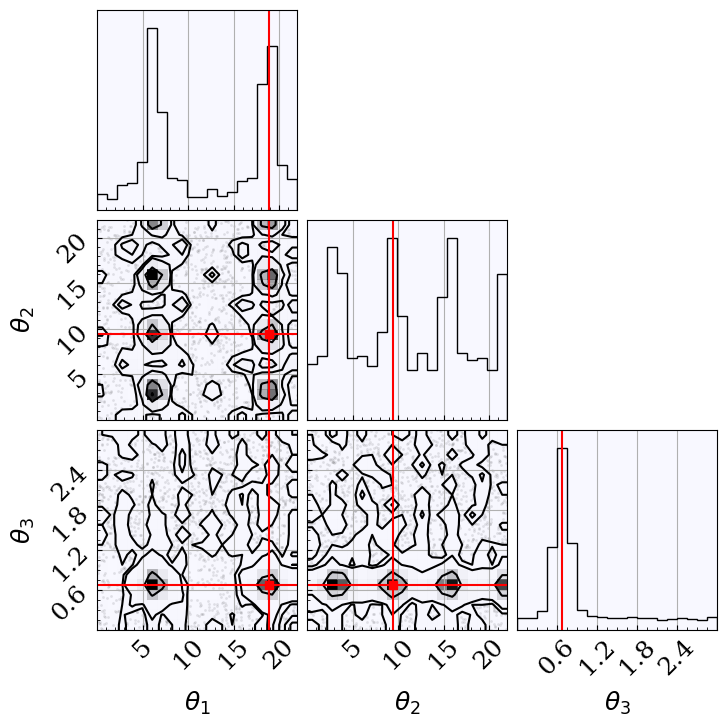

In [46]:
import corner 

# Plot the corner plot

fig = corner.corner(result.samples, labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
                    truths=[nested_theta_max[0], nested_theta_max[1], nested_theta_max[2]], 
                    truth_color='red')

if save_plots:
    plt.savefig('Figures/Prob3_corner', bbox_inches='tight')

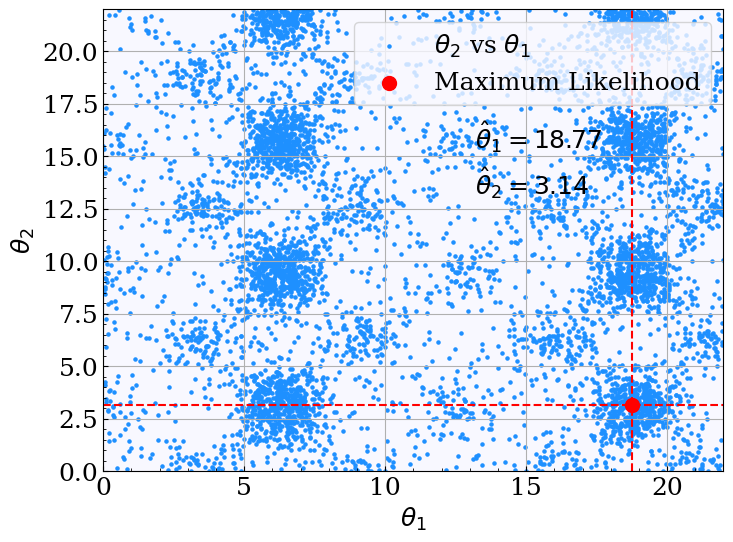

In [42]:
# Plot theta2 samples against theta1 samples

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(result.samples[:, 0], result.samples[:, 1], s=5, label=r'$\theta_2$ vs $\theta_1$')
ax.vlines(nested_theta_max[0], theta_bounds[1, 0], theta_bounds[1, 1], color='red', ls='--')
ax.hlines(nested_theta_max[1], theta_bounds[0, 0], theta_bounds[0, 1], color='red', ls='--')
ax.scatter(nested_theta_max[0], nested_theta_max[1], s=100, color='red', label='Maximum Likelihood')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_xlim(theta_bounds[0])
ax.set_ylim(theta_bounds[1])
ax.legend(loc='upper right')
ax.grid(True)

# Text with theta 1 and 2 maximum likelihood values
ax.text(0.6, 0.7, f"$\hat{{\\theta}}_1 = {nested_theta_max[0]:.2f}$", transform=ax.transAxes)
ax.text(0.6, 0.6, f"$\hat{{\\theta}}_2 = {nested_theta_max[1]:.2f}$", transform=ax.transAxes)


if save_plots:
    plt.savefig("Figures/Prob3_t1_t2.png", dpi=300)

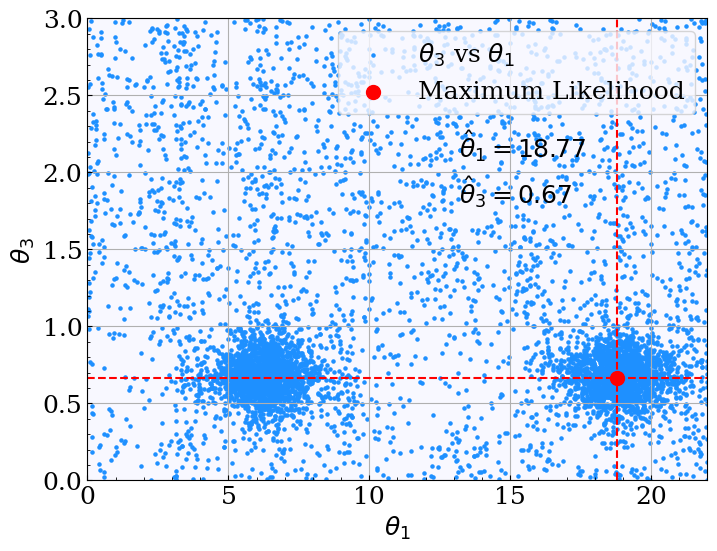

In [44]:
# Plot theta3 samples against theta1 samples

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(result.samples[:, 0], result.samples[:, 2], s=5, label=r'$\theta_3$ vs $\theta_1$')
ax.vlines(nested_theta_max[0], theta_bounds[2, 0], theta_bounds[2, 1], color='red', ls='--')
ax.hlines(nested_theta_max[2], theta_bounds[0, 0], theta_bounds[0, 1], color='red', ls='--')
ax.scatter(nested_theta_max[0], nested_theta_max[2], s=100, color='red', label='Maximum Likelihood')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_3$")
ax.set_xlim(theta_bounds[0])
ax.set_ylim(theta_bounds[2])
ax.legend(loc='upper right')
ax.grid(True)

# Text with theta 1 and 3 maximum likelihood values
ax.text(0.6, 0.7, f"$\hat{{\\theta}}_1 = {nested_theta_max[0]:.2f}$", transform=ax.transAxes)
ax.text(0.6, 0.6, f"$\hat{{\\theta}}_3 = {nested_theta_max[2]:.2f}$", transform=ax.transAxes)

if save_plots:
    plt.savefig("Figures/Prob3_t1_t3.png", dpi=300)

### Problem 3b 

In [60]:
# Make a 2D raster scan of the likelihood function
# For theta1 and theta2 and constant theta3

N_steps = 500

theta1_arr = np.linspace(theta_bounds[0, 0], theta_bounds[0, 1], N_steps)
theta2_arr = np.linspace(theta_bounds[1, 0], theta_bounds[1, 1], N_steps)
theta3_const = nested_theta_max[2]

likelihood_map1 = np.zeros((len(theta1_arr), len(theta2_arr)))

for i, t2 in enumerate(theta2_arr):
    for j, t1 in enumerate(theta1_arr):
        likelihood_map1[i, j] = log_likelihood([t1, t2, theta3_const])

In [61]:
# Find the maximum likelihood
max_likelihood1 = np.max(likelihood_map1)
idx1 = np.unravel_index(np.argmax(likelihood_map1, axis=None), likelihood_map1.shape)
max_params1 = [theta1_arr[idx1[1]], theta2_arr[idx1[0]]]

# Print the maximum likelihood values
print("theta1 = {0:5.2f}".format(max_params1[0]))
print("theta2 = {0:5.2f}".format(max_params1[1]))

theta1 = 18.86
theta2 = 21.99


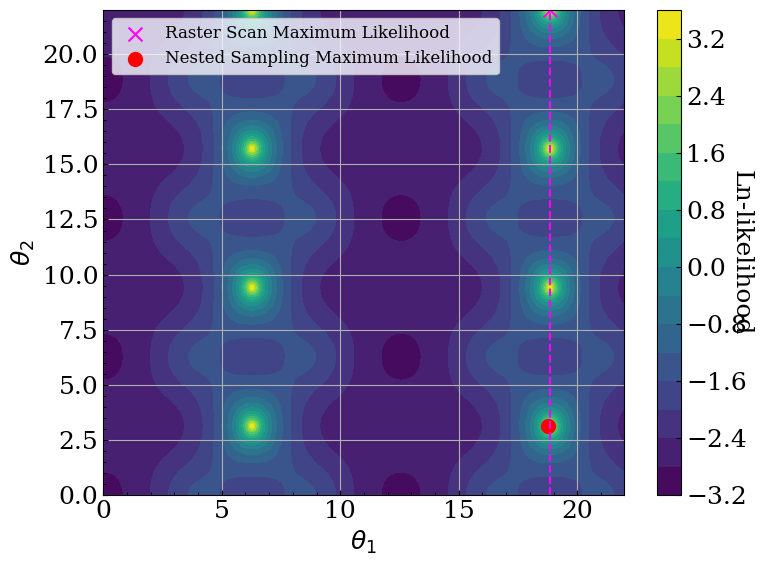

In [63]:
# Plot the likelihood map

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
c = ax.contourf(theta1_arr, theta2_arr, likelihood_map1, levels=20)
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('Ln-likelihood', rotation=270)

ax.vlines(max_params1[0], theta_bounds[1, 0], theta_bounds[1, 1], color='magenta', ls='--')
ax.hlines(max_params1[1], theta_bounds[0, 0], theta_bounds[0, 1], color='magenta', ls='--')
ax.scatter(max_params1[0], max_params1[1], s=100, marker='x', color='magenta', label='Raster Scan Maximum Likelihood')

# Plot the nested sampling maximum likelihood
ax.scatter(nested_theta_max[0], nested_theta_max[1], s=100, color='red', label='Nested Sampling Maximum Likelihood')

ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.grid(True)
ax.legend(loc='upper left', fontsize=12)

fig.tight_layout()

if save_plots:
    plt.savefig("Figures/Prob3_raster1.png", dpi=300)

In [48]:
# Make a 2D raster scan of the likelihood function
# For theta1 and theta3 and constant theta2

theta3_arr = np.linspace(theta_bounds[2, 0], theta_bounds[2, 1], N_steps)
theta2_const = nested_theta_max[1]

likelihood_map2 = np.zeros((len(theta1_arr), len(theta3_arr)))

for i, t3 in enumerate(theta3_arr):
    for j, t1 in enumerate(theta1_arr):
        likelihood_map2[i, j] = log_likelihood(np.array([t1, theta2_const, t3]))

# Find the maximum likelihood
max_likelihood2 = np.max(likelihood_map2)
idx2 = np.unravel_index(np.argmax(likelihood_map2, axis=None), likelihood_map2.shape)
max_params2 = [theta1_arr[idx2[1]], theta3_arr[idx2[0]]]

# Print the maximum likelihood values
print("theta1 = {0:5.2f}".format(max_params2[0]))
print("theta3 = {0:5.2f}".format(max_params2[1]))

theta1 = 18.86
theta3 =  0.68


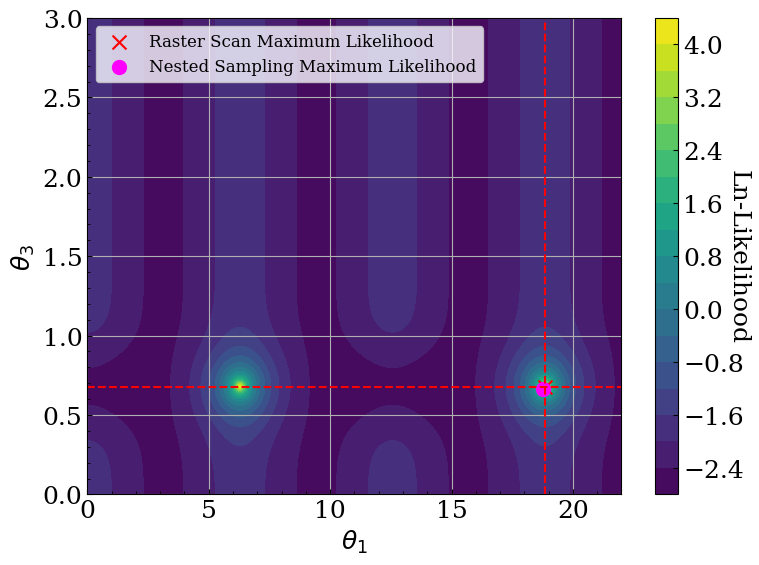

In [72]:
# Plot the likelihood map
      
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
c = ax.contourf(theta1_arr, theta3_arr, likelihood_map2, levels=20)
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('Ln-Likelihood', rotation=270)

ax.vlines(max_params2[0], theta_bounds[2, 0], theta_bounds[2, 1], color='red', ls='--')
ax.hlines(max_params2[1], theta_bounds[0, 0], theta_bounds[0, 1], color='red', ls='--')
ax.scatter(max_params2[0], max_params2[1], s=100, marker='x', color='red', label='Raster Scan Maximum Likelihood')

# Plot the nested sampling maximum likelihood
ax.scatter(nested_theta_max[0], nested_theta_max[2], s=100, color='magenta', label='Nested Sampling Maximum Likelihood')

ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_3$")
ax.grid(True)

ax.legend(loc='upper left', fontsize=12)

fig.tight_layout()

if save_plots:
    plt.savefig("Figures/Prob3_raster2.png", dpi=300)

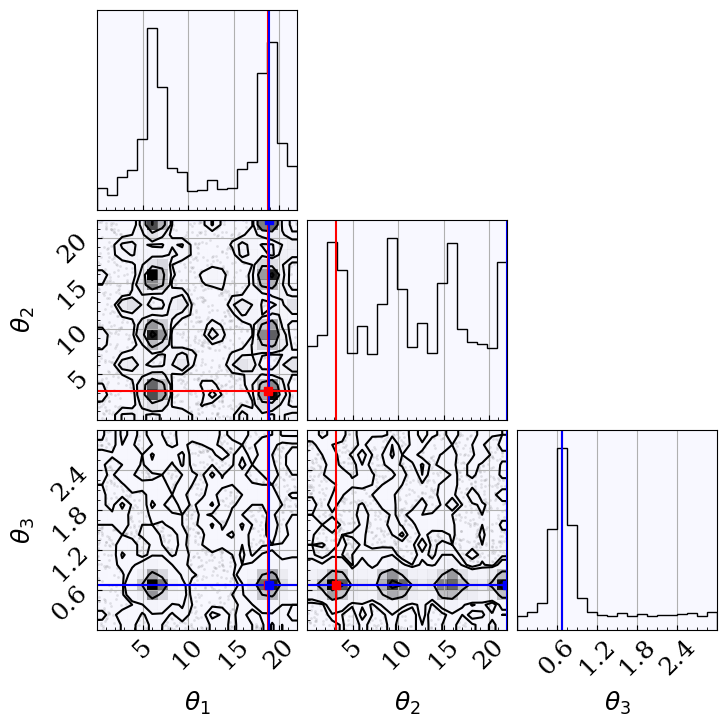

In [71]:
# Plot the corner plot

fig = corner.corner(result.samples, labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

axes = np.array(fig.axes).reshape((ndim, ndim))

# Loop over the diagonal
value1 = nested_theta_max
value2 = np.array([max_params1[0], max_params1[1], nested_theta_max[2]])

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="r")
    ax.axvline(value2[i], color="b")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="r")
        ax.axvline(value2[xi], color="b")
        ax.axhline(value1[yi], color="r")
        ax.axhline(value2[yi], color="b")
        ax.plot(value1[xi], value1[yi], "sr")
        ax.plot(value2[xi], value2[yi], "sb")

if save_plots:
    plt.savefig('Figures/Prob3_corner_extra', bbox_inches='tight')